# Netcdfs for TempestExtreme

In [ ]:
import numpy as np
import xarray as xr
import healpy as hp
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )

In [4]:
def regridder_2D(zoom, timeinterval, data):
    idx = get_nn_lon_lat_index(
            2**zoom, np.arange(-180, 180, .25), np.arange(-90, 90+.25, .25) # 0.25 x 0.25 lon/lat
            )
    da_lon_lat = data.isel(cell=idx)
    da_lon_lat = da_lon_lat.rename({'lon': 'longitude', 'lat': 'latitude'})
    da_lon_lat = da_lon_lat.drop_vars('crs')
    da_lon_lat = da_lon_lat.drop_vars('cell')
    if timeinterval == '3hr':
        da_lon_lat = da_lon_lat.sel(time=da_lon_lat.time.dt.hour.isin([0, 3, 6, 9, 12, 15, 18, 21]))
    elif timeinterval == '6hr':
        da_lon_lat = da_lon_lat.sel(time=da_lon_lat.time.dt.hour.isin([0, 6, 12, 18]))
    ds_lon_lat = da_lon_lat.to_dataset()
    
    ds_lon_lat.time.attrs['long_name'] = 'time'
    ds_lon_lat.latitude.attrs['units'] = 'degrees_north'
    ds_lon_lat.latitude.attrs['long_name'] = 'latitude'
    ds_lon_lat.longitude.attrs['units'] = 'degrees_east'
    ds_lon_lat.longitude.attrs['long_name'] = 'longitude'
    ds_lon_lat.attrs['description'] = 'healpix grid to 0.25x0.25 lon/lat grid'
    
    return ds_lon_lat

In [15]:
def regridder_3D(zoom, timeinterval, data):
    idx = get_nn_lon_lat_index(
            2**zoom, np.arange(-180, 180, .25), np.arange(-90, 90+.25, .25) # 0.25 x 0.25 lon/lat
            )
    da_lev_list = []
    for lev_idx in np.arange(0, data.sizes['pressure']):
        da_lon_lat = data.isel(pressure=lev_idx, cell=idx)
        da_lon_lat = da_lon_lat.rename({'lon': 'longitude', 'lat': 'latitude'})
        da_lon_lat = da_lon_lat.drop_vars('crs')
        da_lon_lat = da_lon_lat.drop_vars('cell')
        da_lev_list.append(da_lon_lat)
    da_lon_lat_lev = xr.concat(da_lev_list, dim='pressure')
    da_lon_lat_lev = da_lon_lat_lev.rename({'pressure': 'level'})

    if timeinterval == '3hr':
        da_lon_lat_lev = da_lon_lat_lev.sel(time=da_lon_lat_lev.time.dt.hour.isin([0, 3, 6, 9, 12, 15, 18, 21]))
    elif timeinterval == '6hr':
        da_lon_lat_lev = da_lon_lat_lev.sel(time=da_lon_lat_lev.time.dt.hour.isin([0, 6, 12, 18]))
    ds_lon_lat_lev = da_lon_lat_lev.to_dataset()
    ds_lon_lat_lev = ds_lon_lat_lev.transpose('time', 'level', 'latitude', 'longitude')

    ds_lon_lat_lev.time.attrs['long_name'] = 'time'
    ds_lon_lat_lev['level'] = ds_lon_lat_lev['level'].astype(float)
    ds_lon_lat_lev.level.attrs['long_name'] = 'pressure_level'
    ds_lon_lat_lev.latitude.attrs['units'] = 'degrees_north'
    ds_lon_lat_lev.latitude.attrs['long_name'] = 'latitude'
    ds_lon_lat_lev.longitude.attrs['units'] = 'degrees_east'
    ds_lon_lat_lev.longitude.attrs['long_name'] = 'longitude'
    ds_lon_lat_lev.attrs['description'] = 'healpix grid to 0.25x0.25 lon/lat grid'
    
    return ds_lon_lat_lev

## Regrid the UM model output

Let's regrid  2D/3D fields for `Zoom = 7` to 0.25x0.25 lon/lat grid

In [ ]:
# zoom level 7
zoom = 7

data_z_1H = f"/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z{str(zoom)}.zarr"
data_z_3H = f"/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT3H.z{str(zoom)}.zarr"

data_zg  = xr.open_zarr(data_z_3H).zg  # geopotential height
data_psl = xr.open_zarr(data_z_1H).psl # air pressure at mean sea level pressure
data_uas = xr.open_zarr(data_z_1H).uas # surface U wind
data_vas = xr.open_zarr(data_z_1H).vas # surface V wind

In [16]:
%%time
data_zg_regrided = regridder_3D(7, '6hr', data_zg)

CPU times: user 38 s, sys: 3.18 s, total: 41.2 s
Wall time: 38.5 s


In [ ]:
%%time
data_zg_regrided = regridder_3D(7, '6hr', data_zg)
data_psl_regrided = regridder_2D(7, '6hr', data_psl)
data_uas_regrided = regridder_2D(7, '6hr', data_uas)
data_vas_regrided = regridder_2D(7, '6hr', data_vas)

CPU times: user 15.4 s, sys: 1.1 s, total: 16.5 s
Wall time: 15.6 s


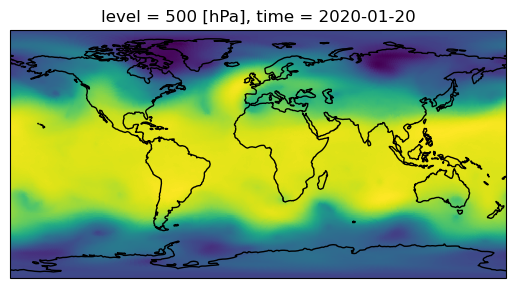

In [ ]:
projection = ccrs.PlateCarree(central_longitude = 0.0)
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
data_zg_regrided['zg'].isel(time=0).sel(level=500).plot(ax = ax, cmap = 'viridis', transform = ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

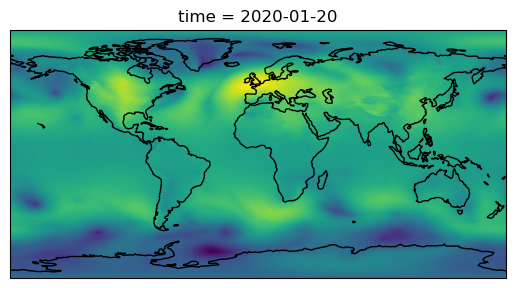

In [24]:
projection = ccrs.PlateCarree(central_longitude = 0.0)
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
data_psl_regrided['psl'].isel(time=0).plot(ax = ax, cmap = 'viridis', transform = ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

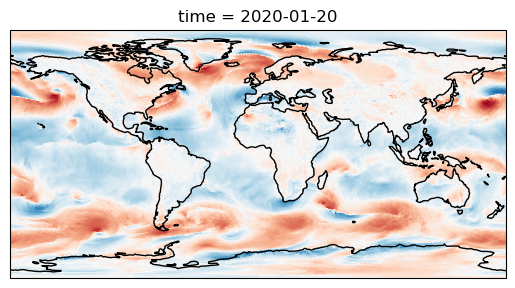

In [25]:
projection = ccrs.PlateCarree(central_longitude = 0.0)
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
data_uas_regrided['uas'].isel(time=0).plot(ax = ax, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

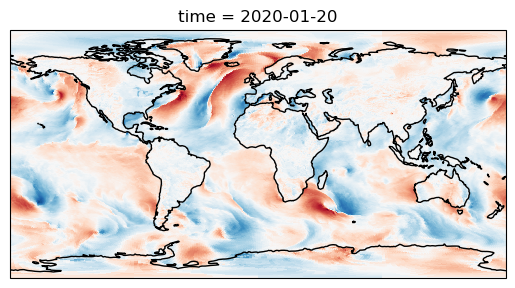

In [26]:
projection = ccrs.PlateCarree(central_longitude = 0.0)
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
data_vas_regrided['vas'].isel(time=0).plot(ax = ax, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

## Save as netcdfs

In [19]:
unique_months = (pd.to_datetime(data_zg_regrided.time.values).to_period('M').unique()).astype(str)

In [29]:
%%time
um_psl_dir = '/scratch/gb02/cj0591/um/psl'
for month in unique_months:
    pslfilename = f'{um_psl_dir}/psl_um_regrided_z{str(zoom)}_{month}.nc'
    data_psl_regrided_month = data_psl_regrided.sel(time=month)
    data_psl_regrided_month.to_netcdf(pslfilename)

In [ ]:
%%time
um_uas_dir = '/scratch/gb02/cj0591/um/uas'
for month in unique_months:
    uasfilename = f'{um_uas_dir}/uas_um_regrided_z{str(zoom)}_{month}.nc'
    data_uas_regrided_month = data_uas_regrided.sel(time=month)
    data_uas_regrided_month.to_netcdf(uasfilename)

In [ ]:
%%time
um_vas_dir = '/scratch/gb02/cj0591/um/vas'
for month in unique_months:
    vasfilename = f'{um_vas_dir}/vas_um_regrided_z{str(zoom)}_{month}.nc'
    data_vas_regrided_month = data_vas_regrided.sel(time=month)
    data_vas_regrided_month.to_netcdf(vasfilename)

In [20]:
%%time
um_zg_dir = '/scratch/gb02/cj0591/um/zg'
for month in unique_months:
    zgfilename = f'{um_zg_dir}/zg_um_regrided_z{str(zoom)}_{month}.nc'
    data_zg_regrided_month = data_zg_regrided.sel(time=month)
    data_zg_regrided_month.to_netcdf(zgfilename)

CPU times: user 38min 51s, sys: 2min 15s, total: 41min 6s
Wall time: 59min 19s
